<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN Classification*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [1]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10)})

%matplotlib inline

In [2]:
breast_cancer_csv = 'dat/breast-cancer-wisconsin-data.csv'
breast_cancer = pd.read_csv(breast_cancer_csv)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [3]:
#get the last columns which is unnamed
breast_cancer.columns[-1]

'Unnamed: 32'

In [4]:
breast_cancer.drop(columns=breast_cancer.columns[-1], 
        axis=1, 
        inplace=True)

In [5]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
breast_cancer.duplicated().sum()

0

### 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [7]:
# ANSWER
y = breast_cancer.diagnosis
y.head()

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

### 4. What is the baseline accuracy?

In [8]:
# ANSWER
base_accuracy_benign = 357 / 569 
base_accuracy_benign

0.6274165202108963

In [9]:
base_accuracy_malignant = 1 - base_accuracy_benign
base_accuracy_malignant

0.37258347978910367

### 5. Choose features to be your predictor variables and set up your X.

In [10]:
# ANSWER
# Take all columns except target as predictor columns
predictor_columns = [c for c in breast_cancer.columns if c != 'diagnosis' and c != 'id']
# Load the dataset as a pandas data frame
X = pd.DataFrame(breast_cancer, columns = predictor_columns)
X.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [11]:
# ANSWER
# Make an instance of a KNeighborsClassifier object with 1 neighbor
neigh = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
neigh.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [12]:
# ANSWER
# predict the response values for the observations in X ("test the model")
neigh.predict(X)

# store the predicted response values
neigh.score(X,y)

1.0

### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [13]:
# ANSWER
# STEP 1: split X and y into training and testing sets (using random_state=42 for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# STEP 2: train the model on the training set (using K=1)
neigh = KNeighborsClassifier(n_neighbors=1)

#fit the model
neigh.fit(X_train,y_train)

# STEP 3: test the model on the testing set, and check the accuracy
test_predict = neigh.predict(X_test)

test_score = neigh.score(X_test,y_test)
print('Accuracy score for testing set: ', test_score)


Accuracy score for testing set:  0.9210526315789473


### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [14]:
# ANSWER
# Create an instance of KNeighborsClassifier where n_neighbors = number of rows in the training data
neigh = KNeighborsClassifier(n_neighbors=len(X_train))

# Fit Train Data
neigh.fit(X_train,y_train)

# Print accuracy_score
test_score = neigh.score(X_test,y_test)
print('Accuracy score for testing set: ', test_score)

Accuracy score for testing set:  0.631578947368421


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [15]:
# fit the KNN from 1 to no. of rows

test_accuracy = []

for k in range(len(X_train)):
    print(k+1)
    neigh = KNeighborsClassifier(n_neighbors=k+1)

    # Fit Train Data
    neigh.fit(X_train,y_train)

    # Print accuracy_score
    test_score = neigh.score(X_test,y_test)
    test_accuracy.append(test_score)
    print('Accuracy score for testing set: ', test_score)

1
Accuracy score for testing set:  0.9210526315789473
2
Accuracy score for testing set:  0.8859649122807017
3
Accuracy score for testing set:  0.9210526315789473
4
Accuracy score for testing set:  0.9385964912280702
5
Accuracy score for testing set:  0.9385964912280702
6
Accuracy score for testing set:  0.9210526315789473
7
Accuracy score for testing set:  0.9385964912280702
8
Accuracy score for testing set:  0.9298245614035088
9
Accuracy score for testing set:  0.9298245614035088
10
Accuracy score for testing set:  0.9210526315789473
11
Accuracy score for testing set:  0.9298245614035088
12
Accuracy score for testing set:  0.9210526315789473
13
Accuracy score for testing set:  0.9210526315789473
14
Accuracy score for testing set:  0.9210526315789473
15
Accuracy score for testing set:  0.9210526315789473
16
Accuracy score for testing set:  0.9122807017543859
17
Accuracy score for testing set:  0.9122807017543859
18
Accuracy score for testing set:  0.9122807017543859
19
Accuracy score f

Accuracy score for testing set:  0.8596491228070176
162
Accuracy score for testing set:  0.8596491228070176
163
Accuracy score for testing set:  0.8596491228070176
164
Accuracy score for testing set:  0.8596491228070176
165
Accuracy score for testing set:  0.8596491228070176
166
Accuracy score for testing set:  0.8596491228070176
167
Accuracy score for testing set:  0.8596491228070176
168
Accuracy score for testing set:  0.8596491228070176
169
Accuracy score for testing set:  0.8596491228070176
170
Accuracy score for testing set:  0.8596491228070176
171
Accuracy score for testing set:  0.8596491228070176
172
Accuracy score for testing set:  0.8596491228070176
173
Accuracy score for testing set:  0.8596491228070176
174
Accuracy score for testing set:  0.8596491228070176
175
Accuracy score for testing set:  0.8596491228070176
176
Accuracy score for testing set:  0.8508771929824561
177
Accuracy score for testing set:  0.8508771929824561
178
Accuracy score for testing set:  0.8508771929824

Accuracy score for testing set:  0.7017543859649122
317
Accuracy score for testing set:  0.7017543859649122
318
Accuracy score for testing set:  0.6842105263157895
319
Accuracy score for testing set:  0.6842105263157895
320
Accuracy score for testing set:  0.6754385964912281
321
Accuracy score for testing set:  0.6754385964912281
322
Accuracy score for testing set:  0.6754385964912281
323
Accuracy score for testing set:  0.6754385964912281
324
Accuracy score for testing set:  0.6754385964912281
325
Accuracy score for testing set:  0.6754385964912281
326
Accuracy score for testing set:  0.6754385964912281
327
Accuracy score for testing set:  0.6754385964912281
328
Accuracy score for testing set:  0.6754385964912281
329
Accuracy score for testing set:  0.6754385964912281
330
Accuracy score for testing set:  0.6754385964912281
331
Accuracy score for testing set:  0.6754385964912281
332
Accuracy score for testing set:  0.6666666666666666
333
Accuracy score for testing set:  0.6666666666666

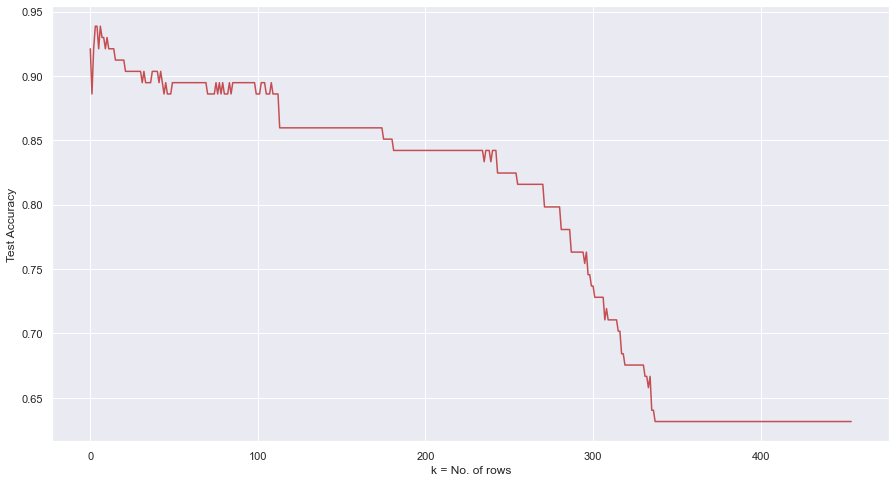

In [16]:
# plot test accuracy by number of neighbors:
test_accuracy_df = pd.DataFrame(test_accuracy)

plt.figure(figsize=[15,8])

plt.ylabel("Test Accuracy")
plt.xlabel("k = No. of rows")

plt.plot(test_accuracy_df, color='r')

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [17]:
cv_scores_list = []

for k in range(len(X_train)):
    #print(k+1)
    neigh = KNeighborsClassifier(n_neighbors=k+1)

    # Fit Train Data
    #neigh.fit(X_train,y_train)

    #train model with cv of 5 
    # Print accuracy_score
    cv_scores = cross_val_score(neigh, X, y, cv=5)
    
    #print each cv score (accuracy) and average them
    #print(cv_scores)
    cv_scores_list.append(np.mean(cv_scores))
    #print('cv_scores mean:{}'.format(np.mean(cv_scores)))
    
print('List of mean cross-validated accuracy: ', cv_scores_list)

List of mean cross-validated accuracy:  [0.9051079024996118, 0.9085700978108988, 0.9191429902189101, 0.9226828132277596, 0.9279459711224964, 0.9209129017233348, 0.9261760596180716, 0.9261915851575843, 0.9314702685918336, 0.9261915851575843, 0.9297003570874087, 0.9314702685918336, 0.9332401800962584, 0.935010091600683, 0.9297314081664337, 0.9297469337059463, 0.9297469337059463, 0.9315013196708586, 0.9297314081664337, 0.9244837758112094, 0.929762459245459, 0.9227138643067846, 0.9227293898462972, 0.9192050923769601, 0.9209594783418723, 0.9174351808725353, 0.9192050923769601, 0.915680794907623, 0.9174351808725353, 0.915680794907623, 0.915680794907623, 0.9174351808725353, 0.920975003881385, 0.9174662319515603, 0.9174662319515603, 0.9156963204471354, 0.9192050923769601, 0.9192050923769601, 0.9174507064120478, 0.9174351808725353, 0.9192206179164726, 0.912156497438286, 0.915680794907623, 0.915680794907623, 0.9192050923769601, 0.9174507064120478, 0.9192050923769601, 0.9121720229777985, 0.913941

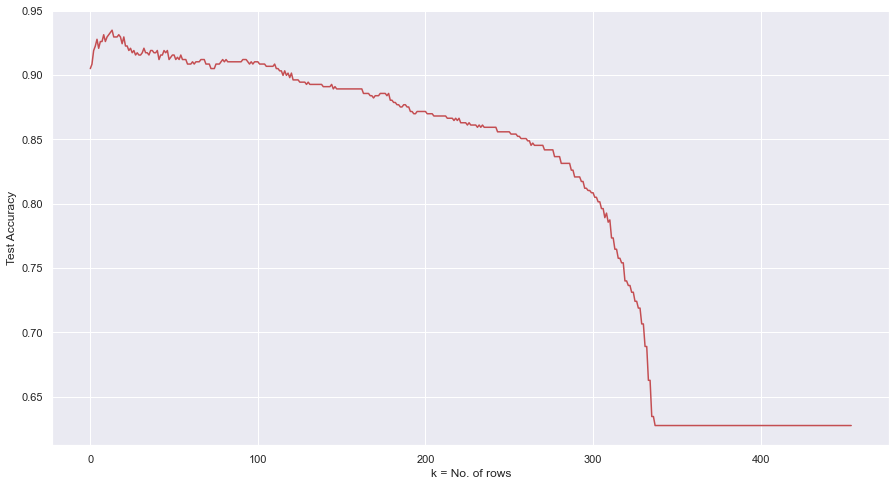

In [18]:
# plot test accuracy by number of neighbors:
cv_scores_df = pd.DataFrame(cv_scores_list)

plt.figure(figsize=[15,8])

plt.ylabel("Test Accuracy")
plt.xlabel("k = No. of rows")

plt.plot(cv_scores_df, color='r')

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [19]:
# ANSWER
# Standarize X


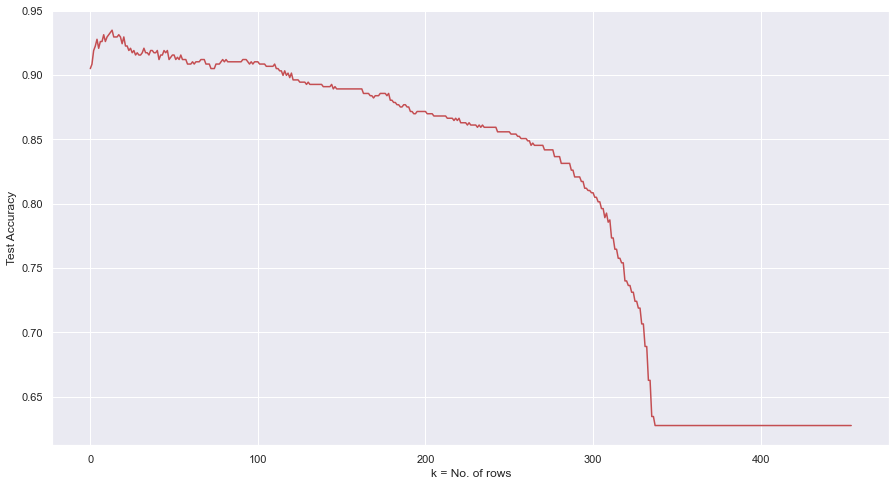

In [20]:
# ANSWER
# plot test accuracy by number of neighbors:
cv_scores_df = pd.DataFrame(cv_scores_list)

plt.figure(figsize=[15,8])

plt.ylabel("Test Accuracy")
plt.xlabel("k = No. of rows")

plt.plot(cv_scores_df, color='r')

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

# Bonus

In [21]:
y = breast_cancer.diagnosis

In [22]:
# Take all columns except target as predictor columns
predictor_columns = [c for c in breast_cancer.columns if c != 'diagnosis' and c != 'id']
# Load the dataset as a pandas data frame
X = pd.DataFrame(breast_cancer, columns = predictor_columns)

In [23]:
breast_cancer.drop(columns=breast_cancer.columns[-1], 
        axis=1, 
        inplace=True)

In [24]:
## Create training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
## Flag intermediate output

show_steps = True   # for testing/debugging
# show_steps = False  # without showing steps

In [26]:
## Use Forward Feature Selection to pick a good model

# start with no predictors
included = []
# keep track of model and parameters
best = {'feature': '', 'r2': 0, 'a_r2': 0}
best_list = []
# create a model object to hold the modelling parameters
model = KNeighborsClassifier()
# get the number of cases in the test data
n = X_test.shape[0]

while True:
    changed = False
    
    if show_steps:
        print('') 

    # list the features to be evaluated
    excluded = list(set(X.columns) - set(included))
    
    if show_steps:
        print('(Step) Excluded = %s' % ', '.join(excluded))  

    # for each remaining feature to be evaluated
    for new_column in excluded:
        
        if show_steps:
            print('(Step) Trying %s...' % new_column)
            print('(Step) - Features = %s' % ', '.join(included + [new_column]))

        # fit the model with the Training data
        fit = model.fit(X_train[included + [new_column]], y_train)
        # calculate the score (R^2 for Regression)
        r2 = fit.score(X_train[included + [new_column]], y_train)
        # number of predictors in this model
        k = len(included + [new_column])
        # calculate the adjusted R^2
        adjusted_r2 = 1 - ( ( (1 - r2) * (n - 1) ) / (n - k - 1) )

        if show_steps:
            print('(Step) - Adjusted R^2: This = %.3f; Best = %.3f' % 
                  (adjusted_r2, best['a_r2']))

        # if model improves
        if adjusted_r2 > best['a_r2']:
            # record new parameters
            best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r2}
            # flag that found a better model
            changed = True
            if show_steps:
                print('(Step) - New Best!   : Feature = %s; R^2 = %.3f; Adjusted R^2 = %.3f' % 
                      (best['feature'], best['r2'], best['a_r2']))
    # END for

    # if found a better model after testing all remaining features
    if changed:
        # update control details
        included.append(best['feature'])
        excluded = list(set(excluded) - set(best['feature']))
        print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
              (best['feature'], best['r2'], best['a_r2']))
        best_list.append(best['r2'])
    else:
        # terminate if no better model
        print('*'*50)
        break

print('')
print('Resulting features:')
print(', '.join(included))


(Step) Excluded = perimeter_se, smoothness_mean, texture_mean, smoothness_se, symmetry_se, symmetry_worst, fractal_dimension_se, compactness_mean, concave points_worst, compactness_se, area_se, symmetry_mean, fractal_dimension_mean, area_mean, area_worst, texture_se, concavity_worst, texture_worst, concavity_mean, concavity_se, concave points_se, radius_mean, fractal_dimension_worst, radius_worst, concave points_mean, radius_se, perimeter_worst, compactness_worst, perimeter_mean, smoothness_worst
(Step) Trying perimeter_se...
(Step) - Features = perimeter_se
(Step) - Adjusted R^2: This = 0.863; Best = 0.000
(Step) - New Best!   : Feature = perimeter_se; R^2 = 0.864; Adjusted R^2 = 0.863
(Step) Trying smoothness_mean...
(Step) - Features = smoothness_mean
(Step) - Adjusted R^2: This = 0.745; Best = 0.863
(Step) Trying texture_mean...
(Step) - Features = texture_mean
(Step) - Adjusted R^2: This = 0.756; Best = 0.863
(Step) Trying smoothness_se...
(Step) - Features = smoothness_se
(Step)

(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying symmetry_worst...
(Step) - Features = perimeter_worst, texture_mean, symmetry_worst
(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying fractal_dimension_se...
(Step) - Features = perimeter_worst, texture_mean, fractal_dimension_se
(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying compactness_mean...
(Step) - Features = perimeter_worst, texture_mean, compactness_mean
(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying concave points_worst...
(Step) - Features = perimeter_worst, texture_mean, concave points_worst
(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying compactness_se...
(Step) - Features = perimeter_worst, texture_mean, compactness_se
(Step) - Adjusted R^2: This = 0.955; Best = 0.957
(Step) Trying area_se...
(Step) - Features = perimeter_worst, texture_mean, area_se
(Step) - Adjusted R^2: This = 0.946; Best = 0.957
(Step) Trying symmetry_mean...
(Step) - Features

(Step) - Adjusted R^2: This = 0.961; Best = 0.964
Added feature radius_mean with R^2 = 0.965 and adjusted R^2 = 0.964

(Step) Excluded = perimeter_se, smoothness_mean, smoothness_se, symmetry_se, symmetry_worst, fractal_dimension_se, compactness_mean, concave points_worst, compactness_se, area_se, symmetry_mean, fractal_dimension_mean, area_mean, area_worst, texture_se, concavity_worst, texture_worst, concavity_mean, concavity_se, concave points_se, fractal_dimension_worst, radius_worst, concave points_mean, radius_se, compactness_worst, smoothness_worst
(Step) Trying perimeter_se...
(Step) - Features = perimeter_worst, texture_mean, perimeter_mean, radius_mean, perimeter_se
(Step) - Adjusted R^2: This = 0.963; Best = 0.964
(Step) Trying smoothness_mean...
(Step) - Features = perimeter_worst, texture_mean, perimeter_mean, radius_mean, smoothness_mean
(Step) - Adjusted R^2: This = 0.963; Best = 0.964
(Step) Trying smoothness_se...
(Step) - Features = perimeter_worst, texture_mean, perim

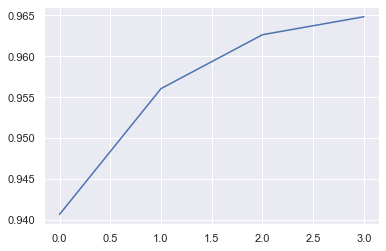

In [27]:
plt.plot(best_list)

In [28]:
best_list

[0.9406593406593406,
 0.9560439560439561,
 0.9626373626373627,
 0.9648351648351648]



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



